# **SALINAS**

**Base-FSL**

Embeddings shape: (111104, 128)


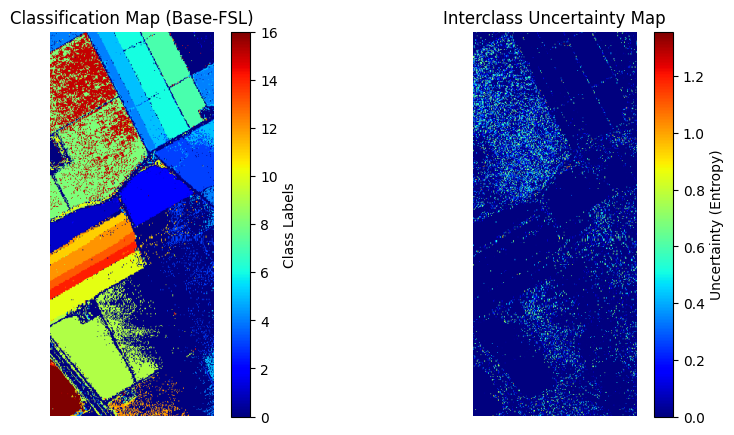

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
import torch.nn as nn

# 1️⃣ Define Spectral Feature Extractor (Same Architecture)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 204, 128)  # 204 spectral bands

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 204) -> (batch, 1, 204)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# 2️⃣ Define Prototypical Network (No Change)
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = torch.cdist(query_embeddings.view(-1, prototypes.shape[-1]), prototypes, p=2) ** 2
        return -dists

# 3️⃣ Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "/content/drive/MyDrive/Model_Checkpoints/PrototypicalNetwork_Salinas.pth"
model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 4️⃣ Load Dataset
file_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df = pd.read_csv(file_path)

# Extract features and labels
X = df.iloc[:, :-1].values  # 204 Spectral bands
y = df.iloc[:, -1].values   # Class labels (0 to 16)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# 5️⃣ **Fix: Process Feature Extraction in Batches (Prevents OOM)**
batch_size = 1024  # Adjust based on GPU memory
num_samples = X_tensor.shape[0]
embeddings_list = []

with torch.no_grad():
    feature_extractor = model.feature_extractor
    for i in range(0, num_samples, batch_size):
        batch = X_tensor[i:i + batch_size]  # Extract batch
        batch_embeddings = feature_extractor(batch).cpu().numpy()
        embeddings_list.append(batch_embeddings)

# Merge all batch embeddings
embeddings = np.vstack(embeddings_list)  # (22213, 128)
print("Embeddings shape:", embeddings.shape)

# 6️⃣ **Fix: Ensure Proper Class-Based Reshaping (Avoids ValueError)**
n_classes = 17  # Class labels range from 0 to 16

# Dictionary to store embeddings for each class
class_embeddings = {i: [] for i in range(n_classes)}

# Assign embeddings based on labels
for idx, label in enumerate(y):
    class_embeddings[label].append(embeddings[idx])

# Convert lists to NumPy arrays and compute class prototypes
prototypes = np.array([np.mean(np.array(class_embeddings[c]), axis=0) for c in range(n_classes)])

# 7️⃣ Compute Distance and Predict Labels
query_embeddings = embeddings  # Assuming all data as the query set
dists = np.linalg.norm(query_embeddings[:, None] - prototypes[None, :], axis=2) ** 2

# Predict class labels
y_pred = np.argmin(dists, axis=1)

# 8️⃣ Compute Uncertainty Using Entropy
probabilities = F.softmax(torch.tensor(-dists), dim=1).numpy()
uncertainty = entropy(probabilities, axis=1)  # Higher entropy = more confusion

# 9️⃣ Reshape Predictions and Uncertainty Map to (512 × 217)
classification_map = y_pred.reshape(512, 217)
uncertainty_map = uncertainty.reshape(512, 217)

# 🔟 Plot Classification and Uncertainty Maps
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(classification_map, cmap="jet")
plt.colorbar(label="Class Labels")
plt.title("Classification Map (Base-FSL)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(uncertainty_map, cmap="jet")
plt.colorbar(label="Uncertainty (Entropy)")
plt.title("Interclass Uncertainty Map")
plt.axis("off")

plt.show()

**Aug-FSL**

Model successfully loaded on cuda
Embeddings shape: (111104, 256)


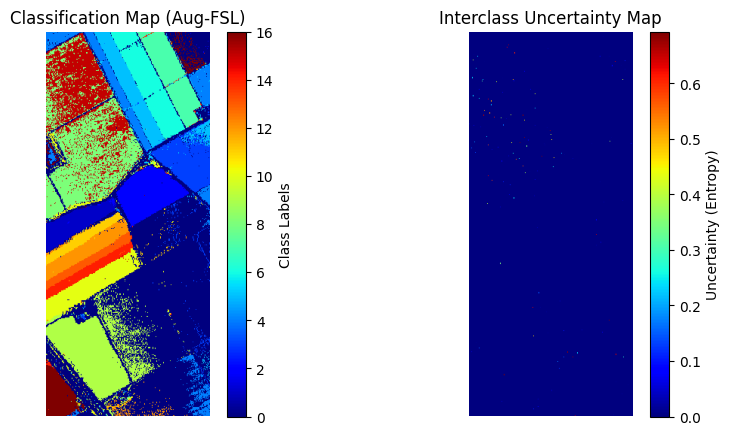

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
import torch.nn as nn

# 1️⃣ Define Improved Spectral Feature Extractor (No Change in Architecture)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc = nn.Linear(256 * 204, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 204) -> (batch, 1, 204)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# 2️⃣ Define Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative for similarity

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        return self.euclidean_distance(query_embeddings, prototypes)

# 3️⃣ Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "/content/drive/MyDrive/Model_Checkpoints/Augmented_PrototypicalNetwork_Salinas.pth"
model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Model successfully loaded on {device}")

# 4️⃣ Load Dataset
file_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df = pd.read_csv(file_path)

# Extract features and labels
X = df.iloc[:, :-1].values  # 204 Spectral bands
y = df.iloc[:, -1].values   # Class labels (0 to 16)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# 5️⃣ **Batch-wise Processing for Feature Extraction (Fixes OOM)**
batch_size = 512  # Adjust based on GPU memory
num_samples = X_tensor.shape[0]
embeddings_list = []

with torch.no_grad():
    feature_extractor = model.feature_extractor
    for i in range(0, num_samples, batch_size):
        batch = X_tensor[i:i + batch_size]  # Extract batch
        batch_embeddings = feature_extractor(batch).cpu().numpy()
        embeddings_list.append(batch_embeddings)

# Merge all batch embeddings
embeddings = np.vstack(embeddings_list)  # (22213, 256)
print("Embeddings shape:", embeddings.shape)

# 6️⃣ **Fix: Compute Class Prototypes Correctly**
n_classes = 17  # Class labels range from 0 to 16

# Dictionary to store embeddings for each class
class_embeddings = {i: [] for i in range(n_classes)}

# Assign embeddings based on labels
for idx, label in enumerate(y):
    class_embeddings[label].append(embeddings[idx])

# Convert lists to NumPy arrays and compute class prototypes
prototypes = np.array([np.mean(np.array(class_embeddings[c]), axis=0) for c in range(n_classes)])

# 7️⃣ Compute Distance and Predict Labels
query_embeddings = embeddings  # Assuming all data as the query set
dists = np.linalg.norm(query_embeddings[:, None] - prototypes[None, :], axis=2) ** 2

# Predict class labels
y_pred = np.argmin(dists, axis=1)

# 8️⃣ Compute Uncertainty Using Entropy
probabilities = F.softmax(torch.tensor(-dists), dim=1).numpy()
uncertainty = entropy(probabilities, axis=1)  # Higher entropy = more confusion

# 9️⃣ Reshape Predictions and Uncertainty Map to (512 × 217)
classification_map = y_pred.reshape(512, 217)
uncertainty_map = uncertainty.reshape(512, 217)

# 🔟 Plot Classification and Uncertainty Maps
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(classification_map, cmap="jet")
plt.colorbar(label="Class Labels")
plt.title("Classification Map (Aug-FSL)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(uncertainty_map, cmap="jet")
plt.colorbar(label="Uncertainty (Entropy)")
plt.title("Interclass Uncertainty Map")
plt.axis("off")

plt.show()

**Cat-FSL**

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 71.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
!pip uninstall -y numpy catboost
!pip install numpy catboost --upgrade

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl (98.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


✅ Model successfully loaded on cuda
Deep feature shape: (111104, 256)
0:	learn: 2.5433988	total: 99.8ms	remaining: 1m 39s
50:	learn: 0.5831119	total: 2.26s	remaining: 42s
100:	learn: 0.3645334	total: 4.27s	remaining: 38s
150:	learn: 0.3058846	total: 7.55s	remaining: 42.5s
200:	learn: 0.2803316	total: 9.94s	remaining: 39.5s
250:	learn: 0.2665441	total: 11.8s	remaining: 35.3s
300:	learn: 0.2561172	total: 13.8s	remaining: 31.9s
350:	learn: 0.2481952	total: 15.7s	remaining: 29s
400:	learn: 0.2413034	total: 17.6s	remaining: 26.3s
450:	learn: 0.2355260	total: 20.6s	remaining: 25.1s
500:	learn: 0.2304632	total: 23.2s	remaining: 23.1s
550:	learn: 0.2259023	total: 25.1s	remaining: 20.5s
600:	learn: 0.2216661	total: 27.1s	remaining: 18s
650:	learn: 0.2177400	total: 29s	remaining: 15.6s
700:	learn: 0.2142483	total: 31s	remaining: 13.2s
750:	learn: 0.2110784	total: 34.2s	remaining: 11.3s
800:	learn: 0.2078806	total: 36.6s	remaining: 9.09s
850:	learn: 0.2050502	total: 38.6s	remaining: 6.75s
900:	le

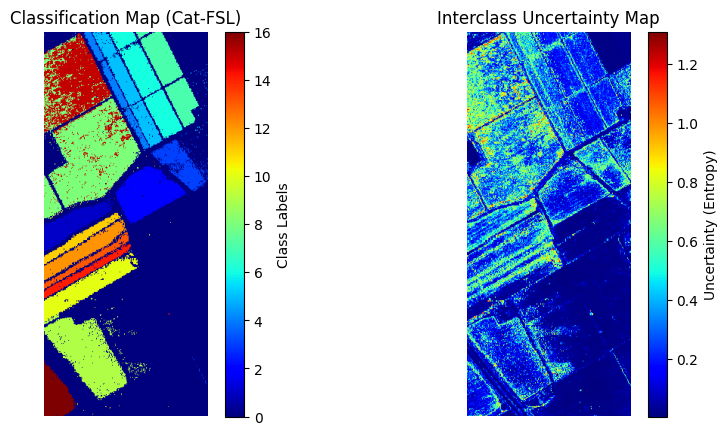

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import os
import torch.nn as nn
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),  # Changed 204 → 1
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# 3️⃣ Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CAT_Boost_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# 4️⃣ Load Dataset
file_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df = pd.read_csv(file_path)

# Extract features and labels
X = df.iloc[:, :-1].values  # 204 Spectral bands
y = df.iloc[:, -1].values   # Class labels (0 to 16)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# 5️⃣ **Batch-wise Deep Feature Extraction**
batch_size = 512  # Adjust based on GPU memory
num_samples = X_tensor.shape[0]

# ✅ Fix input shape before passing to the model
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)  # Now shape is (batch_size, 204, 1)

# ✅ Extract features
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()

# Merge all batch embeddings
deep_features = np.vstack(deep_features)  # Shape: (22213, 256)
print("Deep feature shape:", deep_features.shape)

# 6️⃣ **Train CatBoost on Extracted Deep Features**
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function="MultiClass",
    task_type="GPU",
    verbose=50
)

catboost_model.fit(deep_features, y, verbose=50)

# 7️⃣ **Predict Using CatBoost**
y_pred = catboost_model.predict(deep_features).flatten()

# 8️⃣ Compute Uncertainty Using Entropy
probabilities = catboost_model.predict_proba(deep_features)
uncertainty = entropy(probabilities, axis=1)  # Higher entropy = more confusion

# 9️⃣ Reshape Predictions and Uncertainty Map to (512 × 217)
classification_map = y_pred.reshape(512, 217)
uncertainty_map = uncertainty.reshape(512, 217)

# 🔟 Plot Classification and Uncertainty Maps
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(classification_map, cmap="jet")
plt.colorbar(label="Class Labels")
plt.title("Classification Map (Cat-FSL)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(uncertainty_map, cmap="jet")
plt.colorbar(label="Uncertainty (Entropy)")
plt.title("Interclass Uncertainty Map")
plt.axis("off")

plt.show()

# **IP**

**Base-FSL**

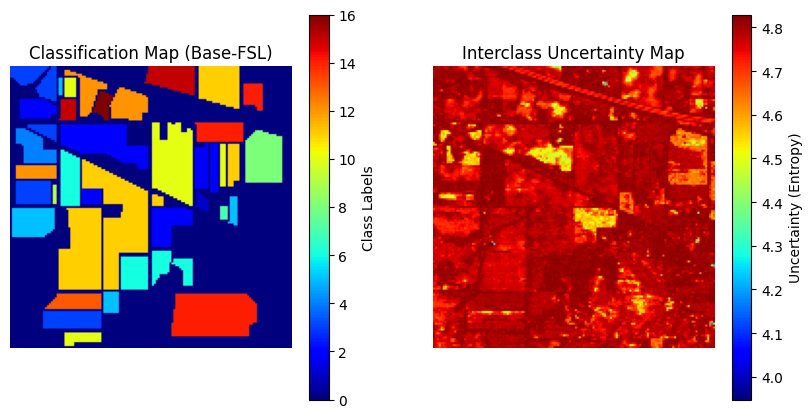

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 200, 128)  # Flattened feature output

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 200) -> (batch, 1, 200)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Ensure correct shape before computing distances
        query_embeddings = query_embeddings.view(-1, prototypes.shape[-1])

        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# Load dataset (Indian Pines CSV)
file_path = "/content/drive/MyDrive/IndianPines.csv"  # Assuming file is uploaded
df_spectral = pd.read_csv(file_path)

# Extract Features from Spectral Data
X = df_spectral.iloc[:, :-1].values  # 200 spectral bands
y_spectral = df_spectral.iloc[:, -1].values   # Class labels

# Normalize the spectral features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# Load model and extract features
model = PrototypicalNetwork().to(device)
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()  # Convert to NumPy

# Classification Map (Reshape to 145x145)
classification_map = y_spectral.reshape(145, 145)

# Compute entropy-based uncertainty
probabilities = np.exp(-embeddings)  # Softmax approximation
probabilities /= probabilities.sum(axis=1, keepdims=True)
uncertainty_map = entropy(probabilities, axis=1).reshape(145, 145)

# Plot Classification and Uncertainty Maps
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(classification_map, cmap="jet")
plt.colorbar(label="Class Labels")
plt.title("Classification Map (Base-FSL)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(uncertainty_map, cmap="jet")
plt.colorbar(label="Uncertainty (Entropy)")
plt.title("Interclass Uncertainty Map")
plt.axis("off")

plt.show()

**Aug-FSL**

Model successfully loaded on cuda


<ipython-input-37-60c1b3eed5a5>:85: RuntimeWarning: overflow encountered in exp
  probabilities = np.exp(-embeddings)  # Softmax approximation
<ipython-input-37-60c1b3eed5a5>:86: RuntimeWarning: invalid value encountered in divide
  probabilities /= probabilities.sum(axis=1, keepdims=True)


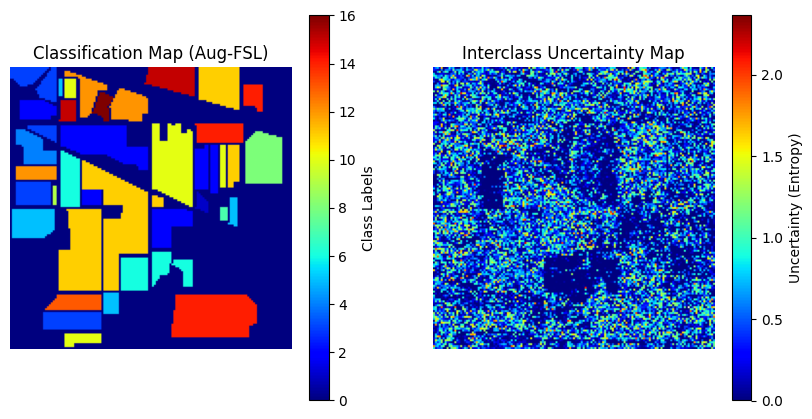

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy

# Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128 * input_dim, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor(input_dim)

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "Augmented_PrototypicalNetwork_IP.pth")

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Determine input dimension dynamically
input_dim = df_spectral.shape[1] - 1  # Exclude class column

# Initialize the model
model = PrototypicalNetwork(input_dim).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

print(f"Model successfully loaded on {device}")

# Extract Features from Spectral Data
X = df_spectral.iloc[:, :-1].values  # First 204 columns as features
y_spectral = df_spectral.iloc[:, -1].values   # Last column as labels (predicted classes)

# Normalize the spectral features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# Extract Features using the trained model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()  # Convert to NumPy for classification

# Classification Map (Reshape to 145x145)
classification_map = y_spectral.reshape(145, 145)

# Compute entropy-based uncertainty
probabilities = np.exp(-embeddings)  # Softmax approximation
probabilities /= probabilities.sum(axis=1, keepdims=True)
uncertainty_map = entropy(probabilities, axis=1).reshape(145, 145)

# Plot Classification and Uncertainty Maps
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(classification_map, cmap="jet")
plt.colorbar(label="Class Labels")
plt.title("Classification Map (Aug-FSL)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(uncertainty_map, cmap="jet")
plt.colorbar(label="Uncertainty (Entropy)")
plt.title("Interclass Uncertainty Map")
plt.axis("off")

plt.show()

**Cat-FSL**

Using device: cuda
✅ Model successfully loaded on cuda


0:	learn: 2.6105418	total: 64.8ms	remaining: 1m 4s
50:	learn: 0.8612365	total: 1.52s	remaining: 28.3s
100:	learn: 0.6206616	total: 2.83s	remaining: 25.2s
150:	learn: 0.5374138	total: 4.22s	remaining: 23.7s
200:	learn: 0.4960051	total: 7.2s	remaining: 28.6s
250:	learn: 0.4715710	total: 8.53s	remaining: 25.5s
300:	learn: 0.4519625	total: 11.3s	remaining: 26.2s
350:	learn: 0.4365905	total: 13.2s	remaining: 24.4s
400:	learn: 0.4246301	total: 14.5s	remaining: 21.7s
450:	learn: 0.4130854	total: 15.8s	remaining: 19.3s
500:	learn: 0.4026922	total: 17.1s	remaining: 17.1s
550:	learn: 0.3930714	total: 18.5s	remaining: 15.1s
600:	learn: 0.3837722	total: 19.8s	remaining: 13.2s
650:	learn: 0.3755704	total: 21.1s	remaining: 11.3s
700:	learn: 0.3671720	total: 22.7s	remaining: 9.68s
750:	learn: 0.3593792	total: 25.8s	remaining: 8.54s
800:	learn: 0.3512847	total: 27.1s	remaining: 6.73s
850:	learn: 0.3437563	total: 28.4s	remaining: 4.97s
900:	learn: 0.3370508	total: 29.7s	remaining: 3.27s
950:	learn: 0.3

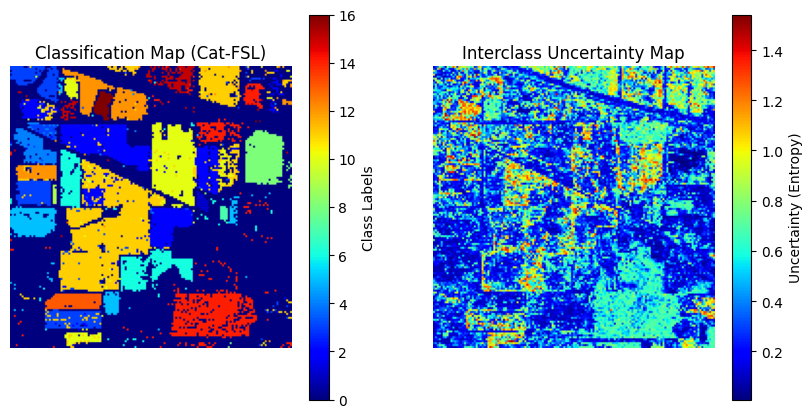

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 200  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# ✅ Extract Features
X = df_spectral.iloc[:, :-1].values  # First 204 columns = Spectral Features
y = df.iloc[:, -1].values   # Class labels (0 to 16)

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Convert to Tensor (Fixing Shape)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)  # Shape: (batch, 204)

# ✅ Fix: Reshape to match Conv1d input (batch, channels, spectral bands)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)  # Shape → (batch, 204, 1)

# ✅ Extract Features using Trained Model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()  # ✅ Convert to NumPy for CatBoost

# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)

catboost_model.fit(deep_features, y, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

# 8️⃣ Compute Uncertainty Using Entropy
probabilities = catboost_model.predict_proba(deep_features)
uncertainty = entropy(probabilities, axis=1)  # Higher entropy = more confusion

# 9️⃣ Reshape Predictions and Uncertainty Map to (512 × 217)
classification_map = y_pred.reshape(145, 145)
uncertainty_map = uncertainty.reshape(145, 145)

# 🔟 Plot Classification and Uncertainty Maps
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(classification_map, cmap="jet")
plt.colorbar(label="Class Labels")
plt.title("Classification Map (Cat-FSL)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(uncertainty_map, cmap="jet")
plt.colorbar(label="Uncertainty (Entropy)")
plt.title("Interclass Uncertainty Map")
plt.axis("off")

plt.show()